# Dealing with filter uncertainty and underdetermined systems

In this tutorial, we will go through some of the basics of dealing with underdetermined system and uncertainty regarding the receptor filters. We will work with the same example from the introduction. However, this time we will also define the uncertainty around our actual filter function (i.e. the standard deviation around the mean filter array).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

import dreye

In [3]:
# wavelength range
wls = np.arange(300, 700, 1)
# peaks of the sensitivities
peaks = np.array([420, 535])
# opsin template
# an empty axis is added to the peaks so that the array object has dimension (opsin_type x wavelengths)
filters = dreye.govardovskii2000_template(wls, peaks[:, None])

led_peaks = np.array([410, 480, 550])
sources = norm.pdf(wls, loc=led_peaks[:, None], scale=20)
sources = sources / dreye.integral(sources, wls, axis=-1, keepdims=True)

est = dreye.ReceptorEstimator(
    # filters array
    filters, 
    # filter uncertainty - in this case it scales with the value of the filter function (heteroscedastic)
    filters_uncertainty=filters * 0.1,
    # wavelength array
    domain=wls, 
    # labels for each photoreceptor type (optional)
    labels=['S', 'L'], 
    # LED array, optional
    sources=sources, 
    # lower bound of each LED, optional
    lb=np.zeros(3), 
    # upper bound for each LED, optional - if None, then the upper bound is infinity
    ub=np.ones(3) * 0.1, 
    # labels for sources, optional
    sources_labels=['V', 'C', 'G']
)

The attribute `Epsilon` defines the variance in capture for each source and filter. `A` defines the mean light-induced capture for each source and filter.

<AxesSubplot:>

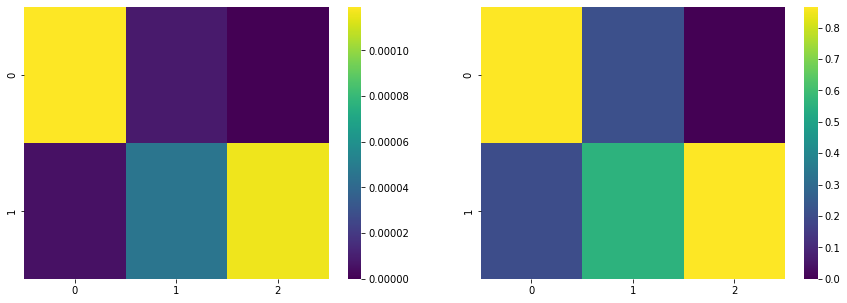

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(
    est.Epsilon, ax=ax1, 
    vmin=0, cmap='viridis'
)
sns.heatmap(
    est.A, ax=ax2,
    vmin=0, cmap='viridis' 
)

In [ ]:
# TODO